In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# Tanh를 구현해봅시다

In [2]:
class Tanh(Model):
    def call(self, x):
        return 2 / (1 + tf.exp(-2*x)) - 1

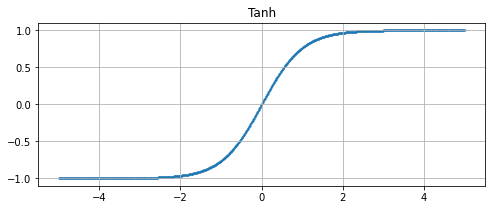

In [3]:
x = tf.linspace(-5, 5, 1000)
y = Tanh()(x)

plt.figure(figsize=[8, 3])
plt.title('Tanh')
plt.scatter(x, y, s=1)
plt.grid()
plt.show()

# Dense층을 구현하세요

In [14]:
class Dense(Model):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.w = tf.random.normal(shape=(input_dim, output_dim))
        self.b = tf.zeros(shape=(output_dim))
        
    def call(self, x):
        # (batch, input_dim)
        # y = W * x + b

        # numpy.matmul (@ operator)
        # @ 연산자, 행렬의 곱연산을 위해 정의된 함수이다.
        # numpy array에서 A: 2x3, B: 3x4 일때, A@B: 2x4로 만들 수 있다.
        # matmul 연산이라고 하며 (n,p) (p,m) = (n,m)로 표시된다.
        y = x @ self.w + self.b
        # @ --> tf.matmul ---> np.dot
        # 2차원 행렬의 곱연산에서는 matmul, dot, @가 모두 같은 결과를 보여준다. 3차원은 다르다.
        return y

In [15]:
t = tf.random.normal((2, 256))
t = Dense(256, 512)(t)
print(t.shape)

(2, 512)


# RNN셀을 구현하세요

$$h^{\prime}=\tanh \left(W_{i h} x+b_{i h}+W_{h h} h+b_{h h}\right)$$

In [44]:
# 참조 : https://blog.naver.com/hgkinm89/222640392230
class RNNCell(Model):
    def __init__(self, input_dim, hidden_dim, activation=Tanh):
        super().__init__()
        self.wi = tf.random.normal(shape=(input_dim, hidden_dim))
        self.bi = tf.zeros(shape=(hidden_dim))      
    
    def call(self, x, h):
        # x : (batch, input_dim)
        y = (x @ self.wi + self.bi) + h
        return y

In [45]:
x = tf.random.normal((2, 16)) # input dim
h = tf.random.normal((2, 32)) # hidden dim

y = RNNCell(16, 32)(x,h)

print(y.shape)

(2, 32)


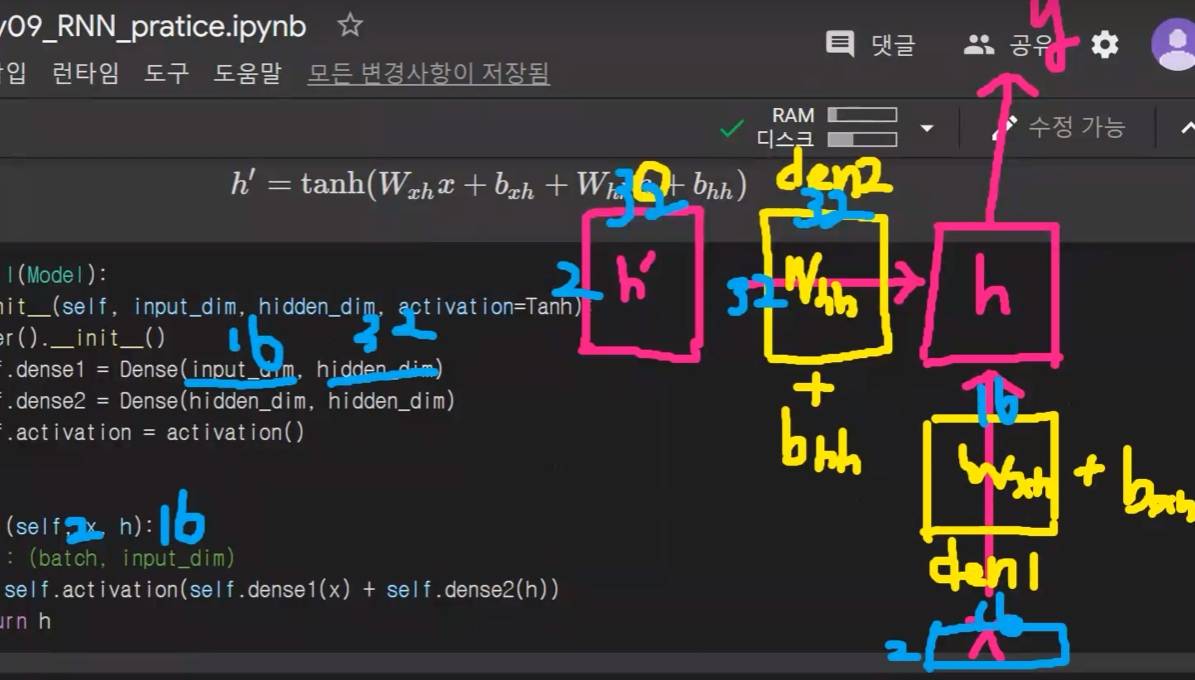

In [48]:
# 강사의 답변 
class RNNCell(Model):
    def __init__(self, input_dim, hidden_dim, activation=Tanh):
        super().__init__()
        self.dense1 = Dense(input_dim, hidden_dim)
        self.dense2 = Dense(hidden_dim, hidden_dim)
        self.activation = activation()
    
    def call(self, x, h):
        # x : (batch, input_dim)
        h = self.activation(self.dense1(x) + self.dense2(h))
        return h

In [49]:
x = tf.random.normal((2, 16)) # input dim
h = tf.random.normal((2, 32)) # hidden dim

y = RNNCell(16, 32)(x,h)

print(y.shape)

(2, 32)


RNN는 RNNCell을 sub-layer로 갖고 있습니다.

forward pass를 구현하는 call에서 for loop 통해 매 time step의 vector를 RNNCell에 넣고 hidden state를 출력합니다.

출력된 hidden state는 다음 time step의 hidden state 입력으로 들어갑니다.

첫번째 time step에서는 주어진 hidden state가 없으므로 tf.zeros를 이용하여 0으로 채운 벡터를 사용합니다.

모든 time step의 출력은 for loop이 끝난 뒤, tf.stack 명령을 통해 쌓아서 최종 출력으로 만듭니다.

In [50]:
class RNN(Model):
    def __init__(self, input_dim, hidden_dim, activation=Tanh):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn_cell = RNNCell(input_dim, hidden_dim, activation)
    
    def call(self, x):
        # x : (batch, length(timestep), input_dim)
        batch, length, input_dim = x.shape

        h = tf.zeros((batch, self.hidden_dim))# 초기 벡터를 0으로 설정
        y = []
        for l in range(length):
            x_ = x[:, l, :] # l은 단어로 들어온다.
            h = self.rnn_cell(x_, h)
            y.append(h)
        y = tf.stack(y, axis=1)
        return y

In [52]:
x = tf.random.normal((2, 100, 16)) # input dim

y = RNN(16, 32)(x)
print(y.shape)
print(y)

(2, 100, 32)
tf.Tensor(
[[[-0.99999976  0.99940574 -1.         ...  1.          0.99998975
   -0.8953445 ]
  [ 1.         -0.99999994  0.99998546 ... -0.9999227  -0.40795583
   -1.        ]
  [ 1.         -0.9968566  -0.9999996  ... -0.9999298  -0.83479595
    0.9291527 ]
  ...
  [-0.98773557  0.9941727  -1.         ... -0.99977887 -1.
   -0.98813283]
  [ 1.          0.9045347   0.88523805 ... -0.704582   -0.9996166
    0.4249308 ]
  [-0.5850142   0.4959525   0.15859115 ...  1.         -0.9999162
    0.9997885 ]]

 [[-0.9962771   0.9088273   0.58903515 ...  0.9968443  -0.9999867
    0.79572904]
  [ 1.          0.75779605  0.88742006 ...  0.8374094  -0.99999994
   -0.9893774 ]
  [ 0.7562789  -0.77898985 -0.9997057  ... -0.99997663  0.9999497
    1.        ]
  ...
  [ 1.         -0.99999934  0.9999895  ... -1.         -0.97884387
    0.99912035]
  [-0.69454587  0.99295056 -0.9993675  ... -1.         -1.
    1.        ]
  [ 0.9853474   0.9993715   0.93004847 ...  1.         -0.9999882
   

# GRUCell을 구현해봅시다.

\begin{aligned}
&r=\sigma\left(W_{i r} x+b_{i r}+W_{h r} h+b_{h r}\right) \\
&z=\sigma\left(W_{i z} x+b_{i z}+W_{h z} h+b_{h z}\right) \\
&n=\tanh \left(W_{i n} x+b_{i n}+r *\left(W_{h n} h+b_{h n}\right)\right) \\
&h^{\prime}=(1-z) * n+z * h
\end{aligned}

r : Reset Gate,이전 hidden state의 값을 얼마나 활용할 것인지에 대한 정보

z : Update Gate, 과거와 현재의 정보를 얼마나 반영할 것인지에 대한 비율을 구한다.

n :  전 시점의 hidden state에 reset gate를 곱하여 계산

h' :  : tensor containing the next hidden state for each element in the batch, 현재 정보를 얼마나 사용할지 반영합니다. 그리고 (1-z)는 과거 정보에 대해서 얼마나 사용할지 반영합니다. 그래서 각 역할을 LSTM의 input, forget gate로 볼 수 있고 최종적으로 (4)식을 통해 현 시점의 출력값 hidden state를 구할 수 있습니다.

In [54]:
class Sigmoid(Model):
    def call(self, x):
        return 1 / (1 + np.exp(-x))

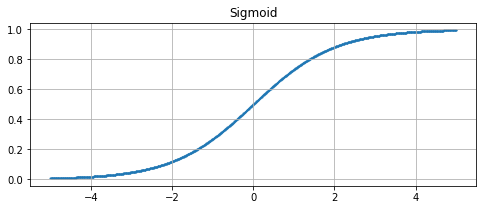

In [56]:
x = tf.linspace(-5, 5, 1000)
y = Sigmoid()(x)

plt.figure(figsize=[8, 3])
plt.title('Sigmoid')
plt.scatter(x, y, s=1)
plt.grid()
plt.show()

In [59]:
class GRUCell(Model):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.sigmoid = Sigmoid()
        self.tanh = Tanh()
        self.dense_ir = Dense(input_dim, hidden_dim)
        self.dense_hr = Dense(hidden_dim, hidden_dim)
        self.dense_iz = Dense(input_dim, hidden_dim)
        self.dense_hz = Dense(hidden_dim, hidden_dim)
        self.dense_in = Dense(input_dim, hidden_dim)
        self.dense_hn = Dense(hidden_dim, hidden_dim)  

    def call(self, x, h):
        # x : (batch, input_dim)
        # h : (batch, hidden_dim)
        r = self.sigmoid(self.dense_ir(x) + self.dense_hr(h))
        z = self.sigmoid(self.dense_iz(x) + self.dense_hz(h))
        n = self.tanh(self.dense_in(x) + r * self.dense_hn(h))
        h = (1-z) * n + z*h
        return h

In [61]:
x = tf.random.normal((2, 16)) # input dim
h = tf.random.normal((2, 32)) # hidden dim

y = GRUCell(16, 32)(x,h)
print(y.shape)

(2, 32)


In [62]:
class GRU(Model):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.gru_cell = GRUCell(input_dim, hidden_dim)
    
    def call(self, x):
        # x : (batch, length, input_dim)
        batch, length, input_dim = x.shape

        h = tf.zeros((batch, self.hidden_dim)) # 초기 벡터를 0으로 설정
        y = []
        for l in range(length):
            x_ = x[:, l, :]
            h = self.gru_cell(x_, h)
            y.append(h)     
        y = tf.stack(y, axis=1)
        return y

In [63]:
x = tf.random.normal((2, 100, 16))
y = GRU(16, 32)(x)
print(y.shape)

(2, 100, 32)


### LSTM을 구현해봅시다.

\begin{aligned}
&i=\sigma\left(W_{i i} x+b_{i i}+W_{h i} h+b_{h i}\right) \\
&f=\sigma\left(W_{i f} x+b_{i f}+W_{h f} h+b_{h f}\right) \\
&g=\tanh \left(W_{i g} x+b_{i g}+W_{h g} h+b_{h g}\right) \\
&o=\sigma\left(W_{i o} x+b_{i o}+W_{h o} h+b_{h o}\right) \\
&c^{\prime}=f * c+i * g \\
&h^{\prime}=o * \tanh \left(c^{\prime}\right)
\end{aligned}

In [64]:
class LSTMCell(Model):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.sigmoid = Sigmoid()
        self.tanh = Tanh()
        self.dense = Dense(input_dim + hidden_dim, hidden_dim*4) # Gate가 4개이기 때문에 hidden_dim*4로 처리
    
    def call(self, x, state):
        # x : (batch, input_dim)
        # state : (batch, hidden_dim), (batch, hidden_dim)
        h, c = state

        # (batch, input_dim + hidden_dim)
        xh = np.concatenate([x, h], axis = 1)

        # (batch, hidden_dim*4)
        d = self.dense(xh)

        i, f, g, o = tf.split(d, 4, axis = 1)

        i = self.sigmoid(i)
        f = self.sigmoid(f)
        g = self.tanh(g)
        o = self.sigmoid(o)
        c_ = f*c + i*g
        h_ = o * self.tanh(c_)
        
        return h_, c_


In [65]:
class LSTM:
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm_cell = LSTMCell(input_dim, hidden_dim)
    
    def __call__(self, x):
        # x : (batch, length, input_dim)
        batch, length, input_dim = x.shape

        h = tf.zeros((batch, self.hidden_dim)) # 초기 벡터를 0으로 초기화
        c = tf.zeros((batch, self.hidden_dim))

        y = [] #결과를 저장할 곳의 초기화 (빈 리스트)
        for l in range(length):
            # batch, length, input_dim
            x_ = x[:, l, :]
            h, c = self.lstm_cell(x_, (h,c))
            y.append(h)
        y = tf.stack(y, axis=1)
        return y

In [66]:
x = tf.random.normal((2, 100, 16))
y = LSTM(16, 32)(x)
print(y.shape)

(2, 100, 32)
